In [1]:
import csv

import pandas as pd

import numpy as np

import torch

from torch import nn, optim

from torch.autograd import Variable

from torch.utils.data import Dataset

from torch.utils.data import DataLoader

import time

import matplotlib.pyplot as plt

In [2]:
# 定义自己的类
class MyDataset(Dataset):
    
    # 初始化
    def __init__(self, file_name):
        # 读入数据
        self.data = pd.read_csv(file_name)
    
    # 返回df的长度
    def __len__(self):
        return len(self.data)
    
    # 获取第idx+1列的数据
    def __getitem__(self, idx):
        return self.data.values[idx,1:10]

# 通过实例化对象来访问该类
# 假设同目录下存在名为median_benchmark.csv的文件
ds = MyDataset('formatweather.csv')
ds=np.asarray(ds[:], dtype = np.float32)#####源文件float32 ,不知道为什么读取变为float64，这里再进行处理  最大最小化时变化
##dl = DataLoader(ds, batch_size=100, shuffle=False)

#####处理为torch，分为trainx，trainy
torchds=torch.from_numpy(ds[:])

In [3]:
# 定义 Recurrent Network 模型

class Rnn(nn.Module):

    def __init__(self, in_dim, hidden_dim, n_layer, n_class):

        super(Rnn, self).__init__()

        self.n_layer = n_layer

        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)

        self.classifier = nn.Linear(hidden_dim, n_class)



    def forward(self, x):

        # h0 = Variable(torch.zeros(self.n_layer, x.size(1),

        #   self.hidden_dim)).cuda()

        # c0 = Variable(torch.zeros(self.n_layer, x.size(1),

        #   self.hidden_dim)).cuda()

        out, _ = self.lstm(x) #out 100 28 128 _ [0]2 100 128 [1]2 100 128

        out = out[:, -1, :]  #100,128

        out = self.classifier(out) #100,10

        return out


In [26]:
class Cnn(nn.Module):

    def __init__(self, in_dim, n_class):

        super(Cnn, self).__init__()

        self.conv = nn.Sequential(

            nn.Conv2d(in_dim, 6, (1,2), stride=(1), padding=(0,1)),#6,1,9

            nn.ReLU(True),

            nn.MaxPool2d(1, 1),#6,1,9

            nn.Conv2d(6, 16, (1,3), stride=(1), padding=(0,1)),

            nn.ReLU(True), nn.MaxPool2d(1, 1))#16,1,9
   
            #5*144

        self.fc = nn.Linear(144, 16)
        
        self.fc1 = nn.Linear(16, 8)
        
        self.fc2 = nn.Linear(8, n_class)



    def forward(self, x):

        out = self.conv(x)

        out = out.view(out.size(0), -1)

        out = self.fc(out)
        
        out1=self.fc1(out)
        
        out=self.fc2(out1)

        return out

In [28]:
cnnmodel = Cnn(1, 1)
cnnmodel.load_state_dict(torch.load('./weathercnn-0.01-true-7.14.pth'))


cnnmodel.eval()
    
#test_x=torchds[:30700,0:8]
test_x=torchds[30700:,0:8]

test_x=test_x.view(-1,1,1,8)

#test_y=torchds[:30700,8]
test_y=torchds[30700:,8]

test_y=test_y.view(-1,1)

test_x=Variable(test_x)

test_y=Variable(test_y)

cnnout = cnnmodel(test_x) #####8

In [6]:
rnnmodel = Rnn(8, 4, 2, 1)  
##model.load_state_dict(torch.load('./weathercnn.pth'))
criterion = nn.MSELoss()
optimizer = optim.SGD(rnnmodel.parameters(), lr=0.01) ####速度很快

In [7]:
train_dataset =cnnout  ##0.7*43823  8
test_dataset  =test_y
dltrain = DataLoader(train_dataset, batch_size=100, shuffle=False)
dltest  = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [8]:
cnnout.size()

torch.Size([30700, 8])

epoch 1
**********
running_loss:-------
0.008240946288483562
epoch 2
**********
running_loss:-------
0.008240515805609961
epoch 3
**********
running_loss:-------
0.008240085314156894
epoch 4
**********
running_loss:-------
0.008239654404134811
epoch 5
**********
running_loss:-------
0.008239223442683323
epoch 6
**********
running_loss:-------
0.00823879218550089
epoch 7
**********
running_loss:-------
0.00823836091815108
epoch 8
**********
running_loss:-------
0.008237929364171198
epoch 9
**********
running_loss:-------
0.008237497520124721
epoch 10
**********
running_loss:-------
0.008237065738646738
epoch 11
**********
running_loss:-------
0.008236633345549861
epoch 12
**********
running_loss:-------
0.008236200567004984
epoch 13
**********
running_loss:-------
0.0082357677689667
epoch 14
**********
running_loss:-------
0.00823533458206759
epoch 15
**********
running_loss:-------
0.008234900956809807
epoch 16
**********
running_loss:-------
0.00823446704806223
epoch 17
**********
run

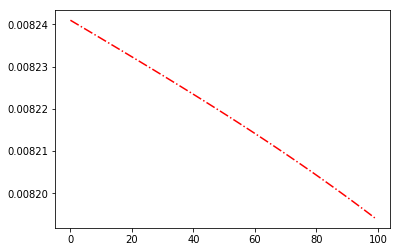

Wall time: 4min 59s


In [23]:
%%time 
losslist=[]
for epoch in range(100):
 
    print('epoch {}'.format(epoch + 1))

    print('*' * 10)

    running_loss = 0.0
    
    dldata=zip(dltrain,dltest)  #cnnout,trainy0.7

    for i, data in enumerate(dldata, 1):
        
            train_x=data[0][:,:]
            
            train_x=train_x.view(-1,1,8)
            
            train_y=data[1][:,0]
            
            train_y=train_y.view(-1,1)
            
            train_x=Variable(train_x)
            
            train_y=Variable(train_y)
        
            out = rnnmodel(train_x)

            loss = criterion(out, train_y)
            
            running_loss += loss.item() * train_y.size(0)
            

            # 向后传播

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
    losslist.append(running_loss / (len(train_dataset)))   
           
                
    print('running_loss:-------')
    print(running_loss / (len(train_dataset)))  
    
plt.plot(losslist,'r-.') 
plt.show()

In [10]:
x=range(0,100)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,train_y.numpy(),'r-.',label='train_y') 
plt.plot(x,out.detach().numpy(),'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

NameError: name 'train_y' is not defined

<Figure size 1296x360 with 0 Axes>

In [24]:
rnnmodel.eval()
    
test_x=torchds[30700:,0:8]

test_x=test_x.view(-1,1,1,8)

test_y=torchds[30700:,8]

test_y=test_y.view(-1,1)

test_x=Variable(test_x)

test_y=Variable(test_y)

testout = cnnmodel(test_x)

testout=testout.view(-1,1,8)

lstmtestout=rnnmodel(testout)

In [20]:
testout.size()

torch.Size([13123, 1, 8])

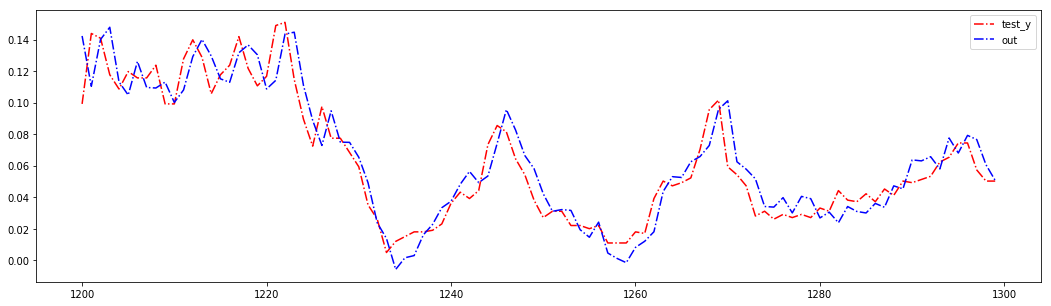

In [30]:
#x=range(0,13123)
x=range(1200,1300)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,test_y.detach().numpy()[1200:1300],'r-.',label='test_y') 
plt.plot(x,cnnout.detach().numpy()[1200:1300],'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()